# Filtro

In [77]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import cv2

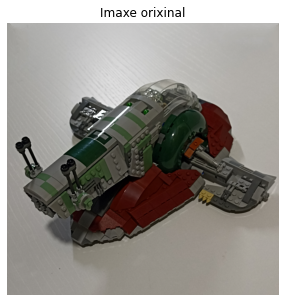

Valor medio da imaxe: 127.45383558506857
Valor medio da imaxe modificada: 123.41504835635712


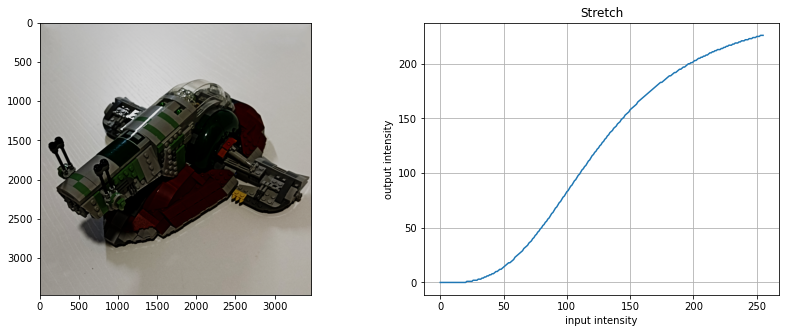

In [95]:
#Cargamos a imaxe
b, g, r = cv2.split(cv2.imread('imaxes/lego6.jpg'))
imaxe = cv2.merge((r, g, b))
#Mostramos a imaxe
plt.imshow(imaxe), plt.title('Imaxe orixinal'), plt.axis('off')
plt.show()

#Calculamos a intensidade media da imaxe
media = 1.0 * imaxe.mean()
m = media
print('Valor medio da imaxe:', media)

#Stretching
E=3
stretchLookUpTable = np.empty(256, np.uint8)
for i in range(256):
    stretchLookUpTable[i] = np.clip(255.0/(1+pow(m/i,E)),0,255) if i else 0
stretch=cv2.LUT(imaxe, stretchLookUpTable)

#Mostramos a imaxe e a gráfica comparando a entrada e saída da intensidade
_, ax = plt.subplots(1, 2,figsize=(14, 5))
ax[0].imshow(stretch), plt.title('Imaxe con stretching'), plt.axis('on')
ax[1].plot(np.arange(0, 256, 1), stretchLookUpTable), plt.grid('on')
ax[1].set_xlabel("input intensity")
ax[1].set_ylabel("output intensity")
ax[1].set_title("Stretch")

#Calculamos o novo valor medio da imaxe, e podemos ver que cambia bastante en comparación ao orixinal
stretchMedia = stretch.mean()
print('Valor medio da imaxe modificada:', stretchMedia)

plt.show()

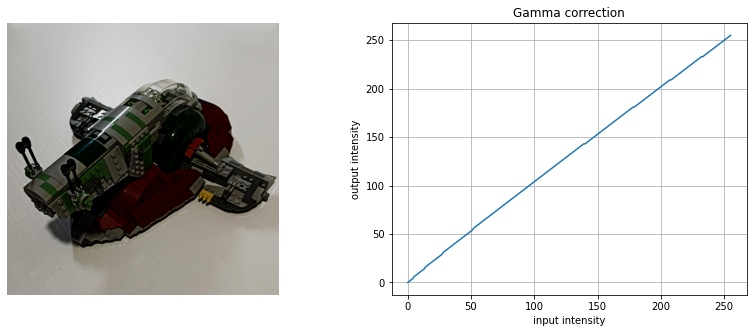

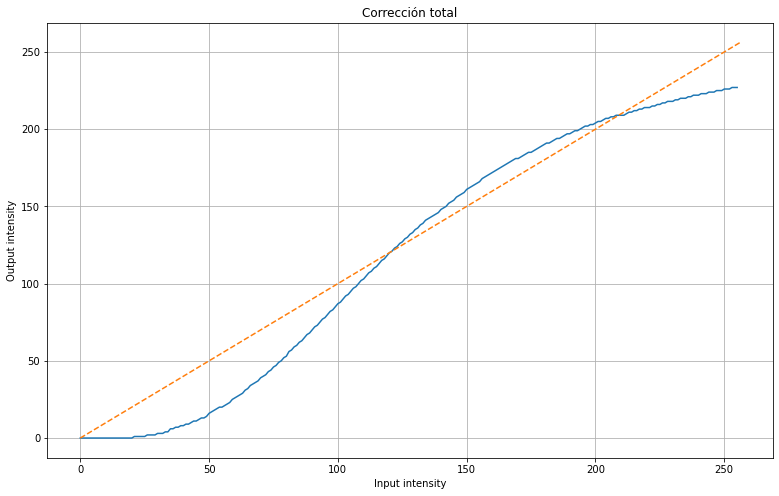

In [96]:
#Calculamos a diferencia de intensidade entre a imaxe orixinal e á que lle apricamos o stretching
#Normalizamos o valor entre 0 e 1
diferencia = 1 - (media - stretchMedia) / 255

#Aumentamos a diferencia elevándoa a un número arbritario, obtido por ensaio e erro ata atopar un que dese bos resultados

if diferencia < 1:
    diferencia = pow(diferencia, 3)
else:
    diferencia = pow(diferencia, 8)

#Utilizaremos a corrección gamma para contrarrestar o cambio global de intensidade do stretching,
#asignando a diferenza ao valor gamma
gamma = diferencia
gammaLookUpTable = np.empty(256, np.uint8)
for i in range(256):
    gammaLookUpTable[i] = np.clip(pow(i/255.0,gamma)*255.0,0,255)
gammaCorrection = cv2.LUT(stretch, gammaLookUpTable)

#Representamos o resultado e a gráfica
_, ax = plt.subplots(1, 2,figsize=(14, 5))
ax[0].imshow(gammaCorrection), ax[0].axis('off')
ax[1].plot(np.arange(0,256,1), gammaLookUpTable), plt.grid('on')
ax[1].set_xlabel("input intensity")
ax[1].set_ylabel("output intensity")
ax[1].set_title("Gamma correction")

plt.show()

#Calculamos os valores da gráfica de axustes totais á intensidade
totalLookUpTable = np.empty(256, np.uint8)
totalLookUpTable = cv2.LUT(stretchLookUpTable, gammaLookUpTable)

#Representamos esta corrección total
x = np.linspace(0, 256, 256)

plt.figure(figsize=(13, 8))

plt.plot(np.arange(0,256,1), totalLookUpTable)
plt.plot(x, x, linestyle = '--')
plt.grid('on')
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Corrección total")

plt.show()

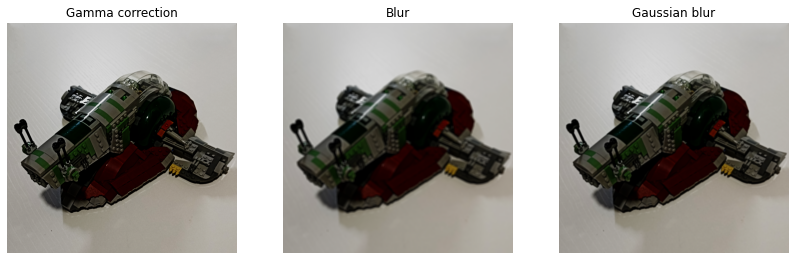

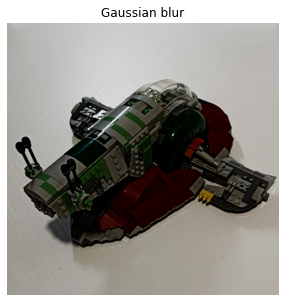

(<matplotlib.image.AxesImage at 0x21d86173ee0>,
 Text(0.5, 1.0, 'Gaussian blur'),
 (-0.5, 3471.5, 3472.5, -0.5),
 None)

In [103]:
#Antes de realizar o resalto de bordos, suavizaremos a imaxe para evitar resaltar ruído
#Estos son dous exemplos esaxerados de suavizado para ver as súas diferenzas, comparándoos coa imaxe orixinal

_, ax = plt.subplots(1, 3,figsize=(14, 5))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].imshow(gammaCorrection)
ax[0].set_title('Gamma correction')

size=40#Tamaño do kérnel
blur = cv2.blur(gammaCorrection,(size,size))
ax[1].imshow(blur)
ax[1].set_title('Blur')

size = 39#O tamaño do kérnel debe ser impar para o gaussiano
gaussianBlur = cv2.GaussianBlur(gammaCorrection,(size,size),0)
ax[2].imshow(gaussianBlur)
ax[2].set_title('Gaussian blur')

plt.show()

#Vendo os resultados, podemos chegar á conclusión de que o gaussiano é o máis adecuado xa que case non difuminará os bordes
size = 9
gaussianBlur = cv2.GaussianBlur(gammaCorrection,(size,size),0)
plt.imshow(gaussianBlur),plt.title('Gaussian blur'),plt.axis('off'),plt.show()

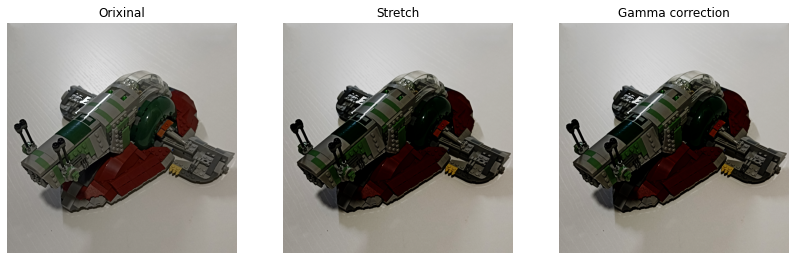

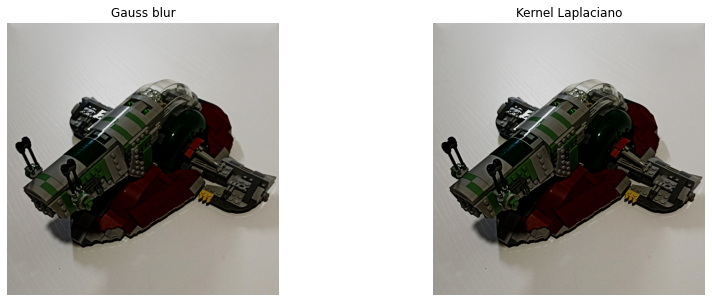

In [105]:
#Invertimos o signo do kérnel laplaciano para aplicar directamente o realce de bordos á imaxe
kernelL=np.array([[-1.0, -1.0, -1.0],
               [-1.0, 9.0, -1.0],#Sumamos ademáis un ao centro para facer que a suma sexa 1 e se vexa a imaxe 
               [-1.0, -1.0, -1.0]])

resultado=cv2.filter2D(gaussianBlur, -1, kernelL)#Aplicamos o kérnel á imaxe (convolución)
realceBordos = cv2.convertScaleAbs(resultado)

#Mostramos unha última comparación dos diferentes pasos
_, ax = plt.subplots(1, 3,figsize=(14, 5))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].imshow(imaxe)
ax[0].set_title('Orixinal')

ax[1].imshow(stretch)
ax[1].set_title('Stretch')
ax[2].imshow(gammaCorrection)
ax[2].set_title('Gamma correction')

plt.show()

_, ax = plt.subplots(1, 2,figsize=(14, 5))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(gaussianBlur)
ax[0].set_title('Gauss blur')

ax[1].imshow(realceBordos)
ax[1].set_title('Kernel Laplaciano')

plt.show()

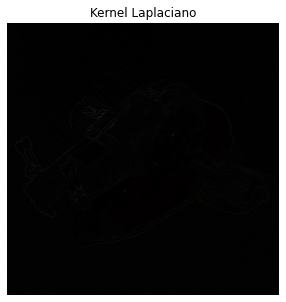

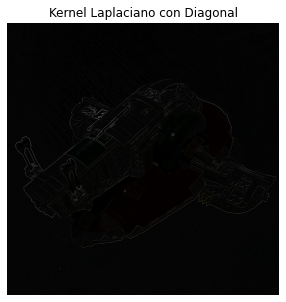

In [107]:
kernelL=np.array([[0.0, 1.0, 0.0],
               [1.0, -4.0, 1.0],
               [0.0, 1.0, 0.0]])
kernelLDiagonal=np.array([[1.0, 1.0, 1.0],
               [1.0, -8.0, 1.0],
               [1.0, 1.0, 1.0]])

resultado=cv2.filter2D(gaussianBlur,-1,kernelL)
dst = 5*cv2.convertScaleAbs(resultado)
plt.imshow(dst,cmap='gray'), plt.title('Kernel Laplaciano'),plt.axis('off')
plt.show()

resultado=cv2.filter2D(gaussianBlur,-1,kernelLDiagonal)
dst = 5*cv2.convertScaleAbs(resultado)
plt.imshow(dst,cmap='gray'), plt.title('Kernel Laplaciano con Diagonal'),plt.axis('off')
plt.show()